# Object segmentation with Region Growing with Shape Prior

Region growing is a classical image segmentation method based on hierarchical region aggregation using local similarity rules. Our proposed method differs from classical region growing in three important aspects. First, it works on the level of superpixels instead of pixels, which leads to a substantial speedup. Second, our method uses learned statistical shape properties which encourage growing leading to plausible shapes. In particular, we use ray features to describe the object boundary. Third, our method can segment multiple objects and ensure that the segmentations do not overlap. The problem is represented as an energy minimization and is solved either greedily, or iteratively using GraphCuts.

Borovec, J., Kybic, J., & Sugimoto, A. (2017). **Region growing using superpixels with learned shape prior.** Journal of Electronic Imaging.

In [1]:
%matplotlib inline
import os, sys, glob
import pickle
import numpy as np
import pandas as pd
from PIL import Image
# from scipy import spatial, ndimage
from skimage import segmentation as sk_segm
import matplotlib.pylab as plt

In [2]:
sys.path += [os.path.abspath('.'), os.path.abspath('..')] # Add path to root
import imsegm.utilities.data_io as tl_io
import imsegm.utilities.drawing as tl_visu
import imsegm.superpixels as seg_spx
import imsegm.region_growing as seg_rg

## Loading data

In [3]:
COLORS = 'bgrmyck'
RG2SP_THRESHOLDS = seg_rg.RG2SP_THRESHOLDS
PATH_IMAGES = os.path.join(tl_io.update_path('data-images'), 'drosophila_ovary_slice')
PATH_DATA = tl_io.update_path('data-images', absolute=True)
PATH_OUT = tl_io.update_path('output', absolute=True)
PATH_MEASURED_RAYS = os.path.join(PATH_IMAGES, 'eggs_ray-shapes.csv')
print ([os.path.basename(p) for p in glob.glob(os.path.join(PATH_IMAGES, '*')) if os.path.isdir(p)])

['center_levels', 'image', 'annot_struct', 'ellipse_fitting', 'annot_eggs', 'segm_rgb', 'segm', 'image_cut-stage-2']


In [4]:
DIR_IMAGES = os.path.join(PATH_IMAGES, 'image')
DIR_SEGMS = os.path.join(PATH_IMAGES, 'segm')
DIR_ANNOTS = os.path.join(PATH_IMAGES, 'annot_eggs')
DIR_CENTERS = os.path.join(PATH_IMAGES, 'center_levels')

## Estimate shape models

In [5]:
def compute_prior_map(cdist, size=(500, 800), step=5):
    prior_map = np.zeros(size)
    centre = np.array(size) / 2
    for i in np.arange(prior_map.shape[0], step=step):
        for j in np.arange(prior_map.shape[1], step=step):
            prior_map[i:i+step, j:j+step] = seg_rg.compute_shape_prior_table_cdf([i, j], cdist, centre, angle_shift=0)
    return prior_map

Visualisation of all normalised Ray features with given angular step.

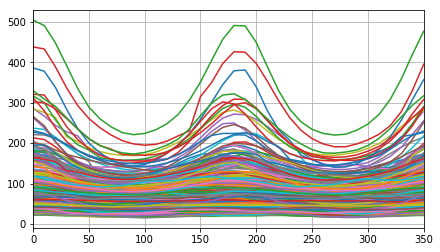

In [7]:
df = pd.read_csv(PATH_MEASURED_RAYS, index_col=0)
list_rays = df.values.tolist()
fig = plt.figure(figsize=(7, 4))
plt.plot(np.linspace(0, 360, len(list_rays[0]) + 1)[:-1], np.array(list_rays).T, '-')
_= plt.xlim([0, 350]), plt.grid()

Visualise the maxima for each egg of measured Ray features.

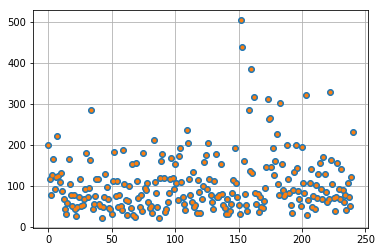

In [8]:
maxima = np.max(list_rays, axis=1)
plt.plot(maxima, 'o'), plt.grid()
# list_rays += [ray * (1 + np.random.random() / 10.) for ray in np.array(list_rays)[maxima > 250]]
# list_rays += [ray * (1 + np.random.random() / 10.) for ray in np.array(list_rays)[maxima > 250]]
_= plt.plot(np.max(list_rays, axis=1), '.')

Estimate and exporting model...

In [9]:
# list_cdf = tl_rg.transform_rays_model_cdf_histograms(list_rays, nb_bins=15)
mm, list_cdf = seg_rg.transform_rays_model_cdf_mixture(list_rays, 15)
cdf = np.array(np.array(list_cdf))
PATH_MODEL_SINGLE = os.path.join(PATH_DATA, 'RG2SP_eggs_single-model.pkl')

with open(PATH_MODEL_SINGLE, 'w') as fp:
    pickle.dump({'name': 'cdf', 'cdfs': cdf, 'mix_model': mm}, fp)

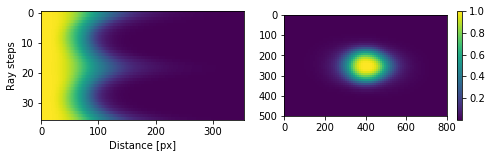

In [11]:
fig = plt.figure(figsize=(8, 2))
plt.subplot(1, 2, 1), plt.imshow(cdf, aspect='auto'), plt.ylabel('Ray steps'), plt.xlabel('Distance [px]')
_= plt.subplot(1, 2, 2), plt.imshow(compute_prior_map(cdf, step=10)), plt.colorbar()
# fig.savefig(os.path.join(PATH_OUT, 'shape-prior.pdf'), bbox_inches='tight')

### Computing shape prior model

Estimate and exporting model...

In [16]:
model, list_mean_cdf = seg_rg.transform_rays_model_sets_mean_cdf_mixture(list_rays, 15)
# model, list_mean_cdf = tl_rg.transform_rays_model_sets_mean_cdf_kmeans(list_rays, 25)
PATH_MODEL_MIXTURE = os.path.join(PATH_DATA, 'RG2SP_eggs_mixture-model.pkl')

with open(PATH_MODEL_MIXTURE, 'w') as fp:
    pickle.dump({'name': 'set_cdfs', 'cdfs': list_mean_cdf, 'mix_model': model}, fp)

Try to load just exported model to verify that it is readeble.

In [17]:
file_model = pickle.load(open(PATH_MODEL_MIXTURE, 'r'))
print (file_model.keys())
list_mean_cdf = file_model['cdfs']
model = file_model['mix_model']

['mix_model', 'cdfs', 'name']


Visualise the set of components from Mixture model and their back reconstructions

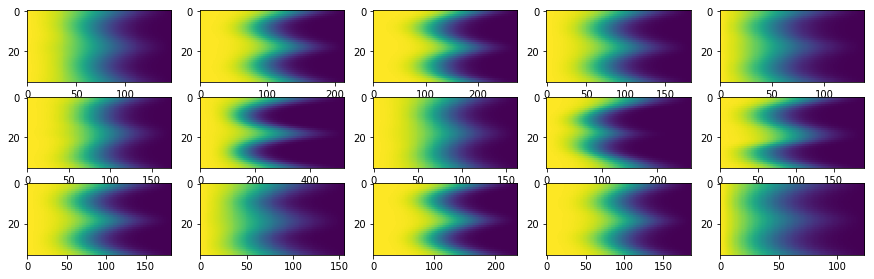

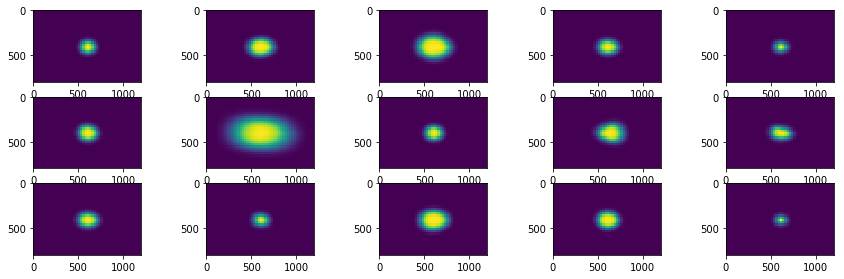

In [19]:
subfig_per_row = 5
subfig_per_col = int(np.ceil(len(list_mean_cdf) / float(subfig_per_row)))
fig = plt.figure(figsize=(3 * subfig_per_row, 1.5 * subfig_per_col))
for i in range(len(list_mean_cdf)):
    plt.subplot(subfig_per_col, subfig_per_row, i+1), plt.imshow(list_mean_cdf[i][1], aspect='auto')
fig = plt.figure(figsize=(3 * subfig_per_row, 1.5 * subfig_per_col))
for i in range(len(list_mean_cdf)):
    plt.subplot(subfig_per_col, subfig_per_row, i+1)
    plt.imshow(compute_prior_map(list_mean_cdf[i][1], size=(800, 1200), step=25))

## Loading Image

In [20]:
name = 'insitu7545'
# name = 'insitu4200'
img = np.array(Image.open(os.path.join(DIR_IMAGES, name + '.jpg')))
seg = np.array(Image.open(os.path.join(DIR_SEGMS, name + '.png')))
# seg = np.array(Image.open(os.path.join(DIR_SEGMS, name + '_gc.png')))
centers = pd.read_csv(os.path.join(DIR_CENTERS, name + '.csv'), index_col=0).values
centers[:, [0, 1]] = centers[:, [1, 0]]
FIG_SIZE = (6. * np.array(img.shape[:2]) / np.max(img.shape))[::-1]
# print centers

Project the structure segmentation with probabbilties for each class

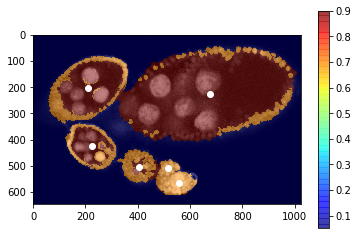

In [21]:
labels_fg_prob = [0.05, 0.7, 0.9, 0.9]
# labels_fg_prob = [0.05, 0.8, 0.95, 0.95]

# plt.figure(figsize=FIG_SIZE)
plt.imshow(img[:, :, 0], cmap=plt.cm.Greys_r)
plt.imshow(np.array(labels_fg_prob)[seg], alpha=0.5, cmap=plt.cm.jet), plt.colorbar()
plt.plot(centers[:, 1], centers[:, 0], 'ow')
_= plt.xlim([0, img.shape[1]]),  plt.ylim([img.shape[0], 0])

### Compute superpixels

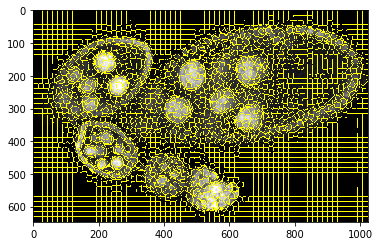

In [22]:
slic = seg_spx.segment_slic_img2d(img, sp_size=15, relative_compact=0.35)
# plt.figure(figsize=FIG_SIZE[::-1])
_= plt.imshow(sk_segm.mark_boundaries(img[:, :, 0], slic))

Loading ipython  (interactive) visualisation functions

In [23]:
from IPython.html import widgets
from IPython.display import display

:0: FutureWarning: IPython widgets are experimental and may change in the future.


## Region growing - Greedy

### Single model

['shifts', 'lut_data_cost', 'lut_shape_cost', 'criteria', 'labels', 'centres']


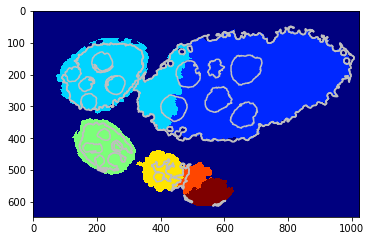

In [24]:
debug_gd_1m = {}
slic_prob_fg = seg_rg.compute_segm_prob_fg(slic, seg, labels_fg_prob)
labels_greedy = seg_rg.region_growing_shape_slic_greedy(slic, slic_prob_fg, centers, (None, cdf), 'cdf', 
                    coef_shape=1., coef_pairwise=5., prob_label_trans=[0.1, 0.01], greedy_tol=2e-1,
                    allow_obj_swap=True, dict_thresholds=RG2SP_THRESHOLDS, nb_iter=250, debug_history=debug_gd_1m)
segm_obj = labels_greedy[slic]
print (debug_gd_1m.keys())
fig = plt.figure(figsize=FIG_SIZE)
_= plt.imshow(segm_obj, cmap=plt.cm.jet), plt.contour(seg, levels=np.unique(seg), colors='#bfbfbf')

Interastive visualisation - over iterations

<function __main__.show_partial>

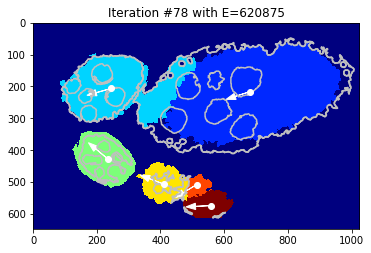

In [25]:
def show_partial(i):
    _= plt.close(), tl_visu.draw_rg2sp_results(plt.figure(figsize=FIG_SIZE).gca(), seg, slic, debug_gd_1m, i)
# show the interact
widgets.interact(show_partial, i=(0, len(debug_gd_1m['criteria']) -1))

### Mixture model

['shifts', 'lut_data_cost', 'lut_shape_cost', 'criteria', 'labels', 'centres']


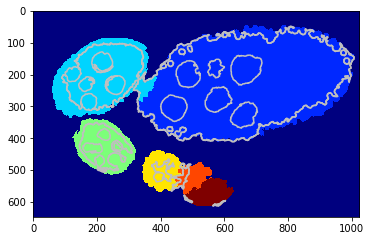

In [26]:
debug_gd_mm = {}
slic_prob_fg = seg_rg.compute_segm_prob_fg(slic, seg, labels_fg_prob)
labels_greedy = seg_rg.region_growing_shape_slic_greedy(slic, slic_prob_fg, centers, (model, list_mean_cdf), 'set_cdfs', 
                    coef_shape=5., coef_pairwise=15., prob_label_trans=[0.1, 0.03], greedy_tol=3e-1,
                    allow_obj_swap=True, dict_thresholds=RG2SP_THRESHOLDS, nb_iter=250, debug_history=debug_gd_mm)
segm_obj = labels_greedy[slic]
print (debug_gd_mm.keys())
fig = plt.figure(figsize=FIG_SIZE)
_= plt.imshow(segm_obj, cmap=plt.cm.jet), plt.contour(seg, levels=np.unique(seg), colors='#bfbfbf')

Interastive visualisation - over iterations

<function __main__.show_partial>

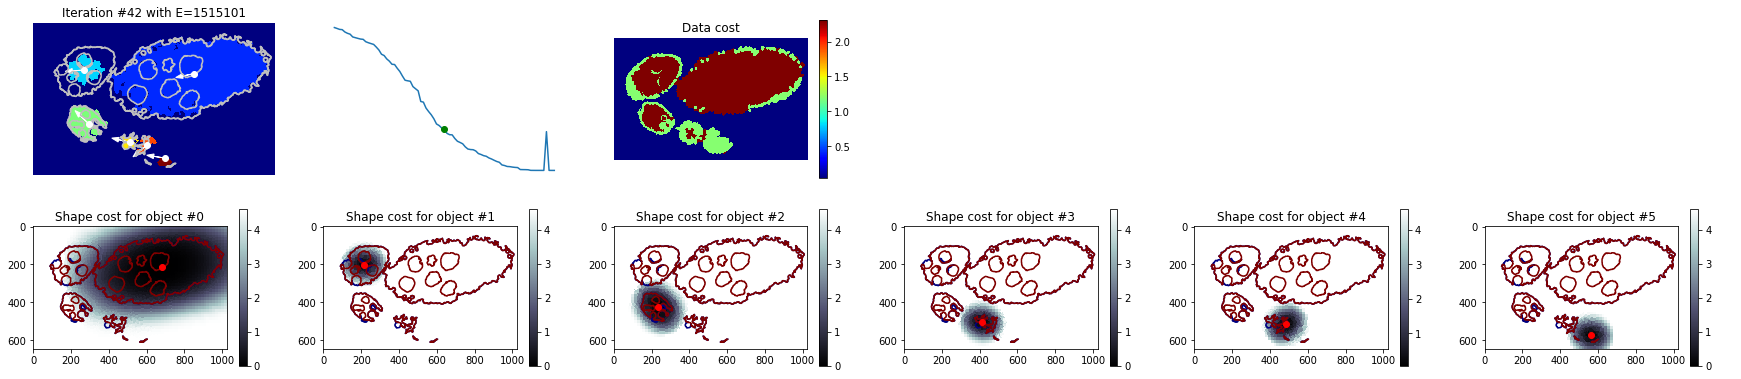

In [27]:
def show_partial(i):
    _= plt.close(), tl_visu.figure_rg2sp_debug_complete(seg, slic, debug_gd_mm, i, max_size=4)
# show the interact
widgets.interact(show_partial, i=(0, len(debug_gd_mm['criteria']) - 1))

### Visualise some iterations

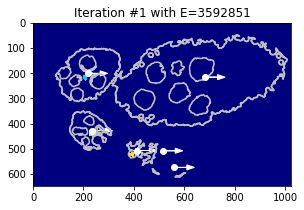

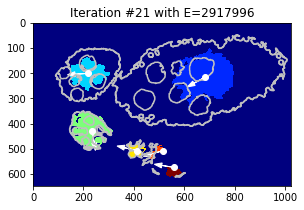

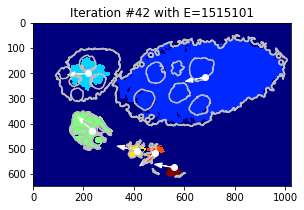

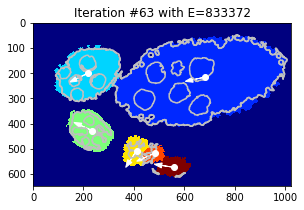

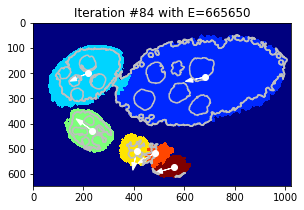

In [28]:
nb_iter = len(debug_gd_mm['criteria'])
for i in np.linspace(1, nb_iter - 1, 5):
    _= tl_visu.draw_rg2sp_results(plt.figure(figsize=(6, 3)).gca(), seg, slic, debug_gd_mm, int(i))

### Exporting iterations

In [35]:
nb_iter = len(debug_gd_mm['criteria'])
fig_size = np.array(FIG_SIZE) * np.array([debug_gd_mm['lut_data_cost'].shape[1] - 1, 2]) / 2.
for i in range(nb_iter):
    fig = plt.figure(figsize=fig_size)    
    tl_visu.draw_rg2sp_results(fig.gca(), seg, slic, debug_gd_mm, int(i))
    plt.savefig(os.path.join(PATH_OUT, 'debug-gd-mm_iter-%03d' % i))
    plt.close(fig)

## Region growing - GraphCut

### Single model

['shifts', 'lut_data_cost', 'lut_shape_cost', 'criteria', 'labels', 'centres']


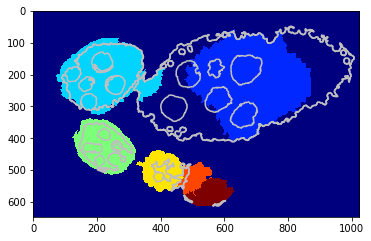

In [29]:
debug_gc_1m = {}
slic_prob_fg = seg_rg.compute_segm_prob_fg(slic, seg, labels_fg_prob)
labels_gc = seg_rg.region_growing_shape_slic_graphcut(slic, slic_prob_fg, centers, (None, cdf), 'cdf', 
                coef_shape=5., coef_pairwise=25., prob_label_trans=[0.1, 0.03], optim_global=True, 
                allow_obj_swap=True, dict_thresholds=RG2SP_THRESHOLDS, nb_iter=65, debug_history=debug_gc_1m)
segm_obj = labels_gc[slic]
print (debug_gc_1m.keys())
fig = plt.figure(figsize=FIG_SIZE)
_= plt.imshow(segm_obj, cmap=plt.cm.jet), plt.contour(seg, levels=np.unique(seg), colors='#bfbfbf')
# print debug_gc_1m.keys(), debug_gc_1m['centres']

Interastive visualisation - over iterations

<function __main__.show_partial>

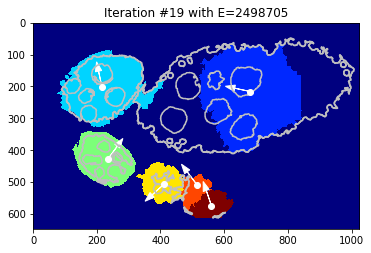

In [30]:
def show_partial(i):
    _= plt.close(), tl_visu.draw_rg2sp_results(plt.figure(figsize=FIG_SIZE).gca(), seg, slic, debug_gc_1m, i)
# show the interact
widgets.interact(show_partial, i=(0, len(debug_gc_1m['criteria']) -1))

### Mixture model

['shifts', 'lut_data_cost', 'lut_shape_cost', 'criteria', 'labels', 'centres']


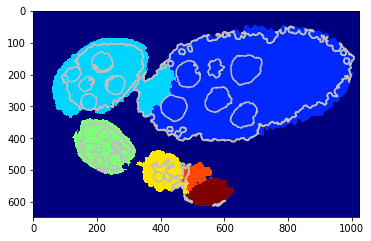

In [31]:
debug_gc_mm = {}
slic_prob_fg = seg_rg.compute_segm_prob_fg(slic, seg, labels_fg_prob)
labels_gc = seg_rg.region_growing_shape_slic_graphcut(slic, slic_prob_fg, centers, (model, list_mean_cdf), 'set_cdfs', 
                coef_shape=5., coef_pairwise=15., prob_label_trans=[0.1, 0.03], optim_global=False, 
                allow_obj_swap=False, dict_thresholds=RG2SP_THRESHOLDS, nb_iter=65, debug_history=debug_gc_mm)
segm_obj = labels_gc[slic]
print (debug_gc_mm.keys())
fig = plt.figure(figsize=FIG_SIZE)
_= plt.imshow(segm_obj, cmap=plt.cm.jet), plt.contour(seg, levels=np.unique(seg), colors='#bfbfbf')

Interastive visualisation - over iterations

<function __main__.show_partial>

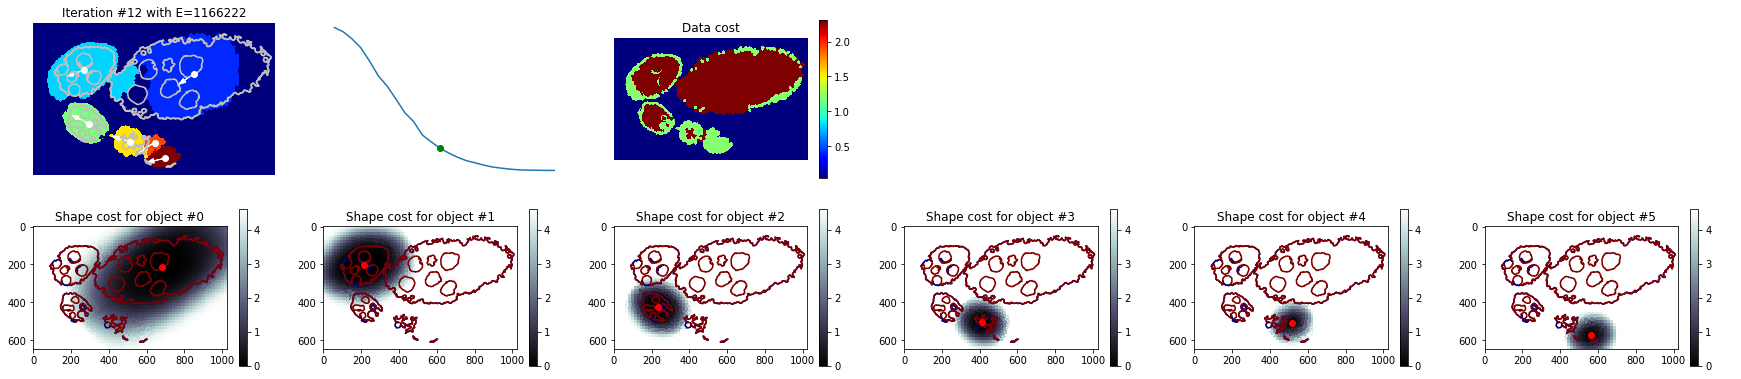

In [32]:
def show_partial(i):
    _= plt.close(), tl_visu.figure_rg2sp_debug_complete(seg, slic, debug_gc_mm, i, max_size=4)
# show the interact
widgets.interact(show_partial, i=(0, len(debug_gc_mm['criteria']) -1))

### Visualise some iterations

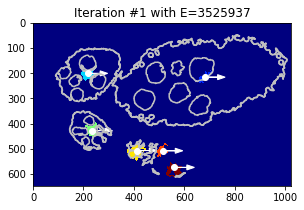

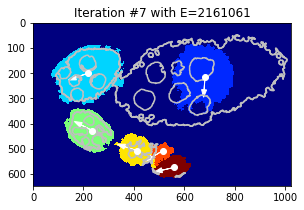

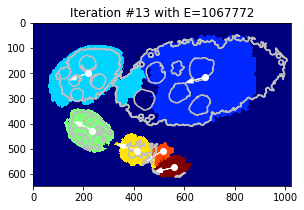

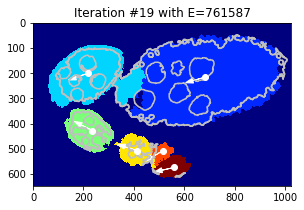

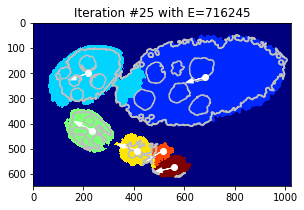

In [34]:
nb_iter = len(debug_gc_mm['criteria'])
for i in np.linspace(1, nb_iter - 1, 5):
    _= tl_visu.draw_rg2sp_results(plt.figure(figsize=(6, 3)).gca(), seg, slic, debug_gc_mm, int(i))

### Exporting iteretions

In [44]:
nb_iter = len(debug_gc_mm['criteria'])
path_out = tl_io.find_path_bubble_up('output')
fig_size = np.array(FIG_SIZE) * np.array([debug_gc_mm['lut_data_cost'].shape[1] - 1, 2]) / 2.
for i in range(nb_iter):
    fig = plt.figure(figsize=fig_size)    
    tl_visu.draw_rg2sp_results(fig.gca(), seg, slic, debug_gc_mm, int(i))
    plt.savefig(os.path.join(path_out, 'debug-gc-mm_iter-%03d' % i))
    plt.close(fig)

## Compare GC and Greedy

Comparing the energy evolving for all strategies

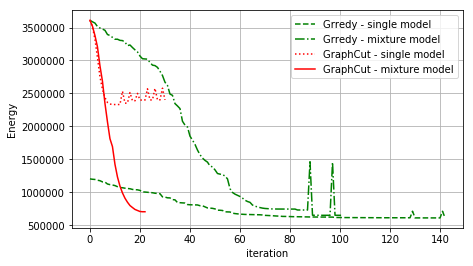

In [31]:
fig = plt.figure(figsize=(7, 4))
plt.plot(debug_gd_1m['criteria'], 'g--', label='Grredy - single model')
plt.plot(debug_gd_mm['criteria'], 'g-.', label='Grredy - mixture model')
plt.plot(debug_gc_1m['criteria'], 'r:', label='GraphCut - single model')
plt.plot(debug_gc_mm['criteria'], 'r-', label='GraphCut - mixture model')
_= plt.ylabel('Energy'), plt.xlabel('iteration'), plt.grid(), plt.legend(loc='upper right')
# fig.subplots_adjust(left=0.15, bottom=0.12, right=0.99, top=0.9)
# fig.savefig(os.path.join(PATH_OUT, 'figure_RG-energy-iter.pdf'))